In [43]:
import librosa
import soundfile as sf
import numpy as np
from google.colab import files
import io

# Upload audio files
#uploaded = files.upload()

# Extract file names
#file_paths = list(uploaded.keys())
#if len(file_paths) != 2:
#    raise ValueError("Please upload exactly two audio files.")

#file1_path = file_paths[0]
#file2_path = file_paths[1]
file1_path = '/content/5895_34615_000009_000001.wav'
file2_path = '/content/5895_34615_000009_000001_f.wav'
# Load audio files
y1, sr1 = librosa.load(file1_path, sr=None)
y2, sr2 = librosa.load(file2_path, sr=None)




In [ ]:
!pip install praat-parselmouth
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 72.8 MB/s eta 0:00:00


In [37]:
#@Author : Guilhem Baissus
#Algorithm written during an internship at Laboratoire d'ingénierie Cognitive Sémantique (Lincs) located in Montreal, Quebec
#My internship was supervised by Sylvie Ratté

import math
import sys
import os
import parselmouth
import pandas as pd

def detect_silences(pathSound, minimum_silence_duration, start, end, frame = 20):
    """
    Method that detects silences for long and short audios by cutting it in frame of 20 seconds
    :params pathSound: path to access to the audio
    :params minimum_silence_duration: the length of the silence pauses to detect
    :params start: parameter of where to start checking for silences in a given audio
    :params end : parameter of where to end checking for silences in a given audio
    :params frame : size of a frame that we check for silences (the frame size influences the accuracy of results returned by parselmouth)
    :returns: an array containing dictionnaries describing the start time, the end time and the duration of a silent pause
    """
    length_extracted_audio = end - start

    outliers = get_outliers(pathSound)
    high_outliers_value = outliers[1]
    low_outliers_value = outliers[0]

    silences = []

    if(length_extracted_audio>frame):
        nb_of_frames = int(length_extracted_audio/frame)
        start_frame = start
        end_frame = start_frame + frame
        for i in range(1, nb_of_frames+1):
            silences += __detect_silence_in_frame(pathSound, start_frame, end_frame, minimum_silence_duration, high_outliers_value,low_outliers_value )
            start_frame +=frame
            end_frame +=frame

        last_end_frame = end_frame - frame
        if last_end_frame < end and end - last_end_frame > 1:
            #Last frame that is not equal to the frame length
            silences+= __detect_silence_in_frame(pathSound, last_end_frame, end, minimum_silence_duration, high_outliers_value, low_outliers_value)
    else:
        silences += __detect_silence_in_frame(pathSound, start, end, minimum_silence_duration, high_outliers_value, low_outliers_value)

    return silences


def __detect_silence_in_frame(pathSound, start_frame, end_frame, minimum_silence_duration, high_outliers_value, low_outliers_value):
    """
    Method that detects silences in a given frame using the fundamental frequency and removes outliers
    :params pathSound: path to access to the audio
    :params start_frame: parameter of where to start checking for silences in a given audio
    :params end_frame : parameter of where to end checking for silences in a given audio
    :params minimum_silence_duration: the length of the silence pauses to detect
    :params high_outliers_value: values higher than this parameter are considered as outliers
    :params low_outliers_value: values lower than this parameter are considered as outliers
    :returns: an array containing dictionnaries describing the start time, the end time and the duration of a silent pause
    """

    silences = []

    sound = parselmouth.Sound(pathSound)
    sound = sound.extract_part(from_time = start_frame , to_time = end_frame)
    pitch = sound.to_pitch()
    pitch_values = pitch.selected_array['frequency']

    start_time_silence = -1
    end_time_silence = -1
    duration = -1
    pauseState = False

    for index, values in enumerate(pitch_values):
        if values==0:
            if pauseState == False:
                start_time_silence = pitch.xs()[index]
                pauseState = True
            #Check if there is silence at the end of the audio
            elif pauseState == True and pitch.xs()[index] == pitch.xs()[-1] and (values > high_outliers_value or values < low_outliers_value):
                silences.append({'start_time': start_frame + start_time_silence, 'end_time': start_frame + pitch.xs()[index], 'duration': pitch.xs()[index] - start_time_silence})
        else:
            if values < high_outliers_value and values > low_outliers_value :
                if pauseState == True :
                    end_time_silence = pitch.xs()[index]
                    duration = end_time_silence - start_time_silence
                    if duration > minimum_silence_duration:
                        silences.append({'start_time': start_frame + start_time_silence, 'end_time': start_frame + end_time_silence, 'duration': duration})

                pauseState = False
    return silences


def get_f0_mean(pathSound, start_time, end_time, voice_max_frequency, voice_min_frequency):
    """
    Method that extracts the f0 mean of a particular sound found at pathSound location without taking in account the 0 values.
    :params pathSound: path to the sound to analyse
    :params start_time: in seconds
    :params end_time : in seconds
    :params voice_max_frequency : maximum frequency of a human being (adult man or adult female)
    :params voice_min_frequency : minimum frequency of a human being (adult man or adult female)
    :returns: mean f0 in the given time
    """
    sound = parselmouth.Sound(pathSound)
    sound = sound.extract_part(from_time = start_time , to_time = end_time)
    pitch = sound.to_pitch()
    pitch_values = pitch.selected_array['frequency']
    pitch_mean = 0
    size= 1
    for values in pitch_values:
        if values!=0:
            pitch_mean += values
            size +=1

    return pitch_mean/size

def get_f0_standard_deviation(pathSound, start_time, end_time, voice_max_frequency, voice_min_frequency):
    """
    Get the standard deviation around a mean
    :params pathSound: path to the sound to analyse
    :params start_time: in seconds
    :params end_time : in seconds
    :params voice_max_frequency : maximum frequency of a human being (adult man or adult female)
    :params voice_min_frequency : minimum frequency of a human being (adult man or adult female)
    :returns: standart deviation of the sound
    """
    sound = parselmouth.Sound(pathSound)
    sound = sound.extract_part(from_time = start_time , to_time = end_time)
    pitch = sound.to_pitch()
    pitch_values = pitch.selected_array['frequency']

    sum = 0
    mean = get_f0_mean(pathSound,start_time, end_time, voice_max_frequency, voice_min_frequency)

    for values in pitch_values:
        if values != 0:
            sum += math.pow(values - mean,2)

    return math.sqrt(sum / len(pitch_values))

def get_outliers(pathSound, voice_max_frequency = 300, voice_min_frequency = 50):
    """
    Method that returns the borders to where to analyse the voice signal
    :params pathSound : path to the audio file
    :params voice_max_frequency : maximum frequency of a human being (adult man or adult female)
    :params voice_min_frequency : minimum frequency of a human being (adult man or adult female)
    """
    outliers = []

    length_audio = getSoundFileLength(pathSound)
    mean_entire_audio = get_f0_mean(pathSound, 0, length_audio, voice_max_frequency, voice_min_frequency)
    standard_deviation_entire_audio = get_f0_standard_deviation(pathSound, 0, length_audio, voice_max_frequency, voice_min_frequency)

    high_outliers_value = mean_entire_audio + 4*standard_deviation_entire_audio
    if high_outliers_value > voice_max_frequency:
        high_outliers_value = voice_max_frequency

    low_outliers_value = mean_entire_audio - 2*standard_deviation_entire_audio
    if low_outliers_value < voice_min_frequency:
        low_outliers_value = voice_min_frequency

    outliers.append(low_outliers_value)
    outliers.append(high_outliers_value)

    return outliers

def getSoundFileLength(pathSound):
    """
    Method that returns the length of a sound file in seconds
    :params pathSound : the path to the sound file
    :returns: the length of sound file in seconds
    """
    sound = parselmouth.Sound(pathSound)
    return sound.xmax - sound.xmin

#-----------------------------------------------------------------------------------------------------------

if len(sys.argv) ==1:
    print("ERROR : python pythonFile.py path_to_sound_files [minimum_silence_duration]")
    sys.exit()

elif len(sys.argv) > 3:
    print("Error : too many arguments given")
    sys.exit()

elif len(sys.argv) == 2:
    MINIMUM_SILENCE_DURATION = 0.5
    PATH_SOUND_FILES = sys.argv[1]

else:
    PATH_SOUND_FILES =sys.argv[1]
    MINIMUM_SILENCE_DURATION = sys.argv[2]


df = pd.DataFrame()

audio_files_list = os.listdir('/content/')
for audios_names in audio_files_list:
    if audios_names[-3:] == "mp3" or audios_names[-3:] == "wav":
        print("Extracting silences for : {}".format(audios_names))

        data = {
            'name_file' : [],
            'start_time' : [],
            'end_time' : [],
            'duration' : []
        }

        path_sound_file = os.path.join(PATH_SOUND_FILES,audios_names)
        path_sound_file = '/content/' + audios_names
        MINIMUM_SILENCE_DURATION = 0.25
        silences = detect_silences(path_sound_file, MINIMUM_SILENCE_DURATION, 0, getSoundFileLength(path_sound_file))

        for values in silences:
            data['name_file'].append(audios_names[:-4])
            data['start_time'].append(values['start_time'])
            data['end_time'].append(values['end_time'])
            data['duration'].append(values['duration'])

        df = pd.DataFrame(data,columns=list(data.keys()))
        df.to_csv(audios_names+"-silences.csv", index = False)



Extracting silences for : 5895_34615_000009_000001.wav
Extracting silences for : 5895_34615_000009_000001_f.wav


In [44]:
# prompt: I want to extract the start time and end times from the csv files arrays of start and end

import pandas as pd

def extract_times(csv_file_path):
    """
    Extracts start and end times from a CSV file.

    Args:
        csv_file_path: The path to the CSV file.

    Returns:
        A tuple containing two lists: start_times and end_times.
        Returns (None, None) if the file does not exist or if there's an error.
    """
    try:
        df = pd.read_csv(csv_file_path)
        start_times = df['start_time'].tolist()
        end_times = df['end_time'].tolist()
        return start_times, end_times
    except FileNotFoundError:
        print(f"Error: File not found at {csv_file_path}")
        return None, None
    except KeyError as e:
        print(f"Error: Column not found in CSV: {e}")
        return None, None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None, None

# Example usage (assuming you have a CSV file named "audio1-silences.csv"):
start_times, end_times = extract_times('/content/5895_34615_000009_000001_f.wav-silences.csv')
start_times_f, end_times_f = extract_times('/content/5895_34615_000009_000001.wav-silences.csv')

if start_times is not None and end_times is not None:
    print("Start Times:", start_times)
    print("End Times:", end_times)
if start_times is not None and end_times is not None:
    print("fake Start Times:", start_times_f)
    print("fake End Times:", end_times_f)


Start Times: [0.2733333333333326, 2.563333333333333, 4.913333333333332, 6.643333333333333, 8.803333333333333, 12.073333333333334]
End Times: [0.5533333333333327, 3.3933333333333326, 5.923333333333333, 6.9433333333333325, 9.643333333333334, 13.993333333333334]
fake Start Times: [2.95, 5.51, 8.29, 9.75, 11.01, 13.33]
fake End Times: [3.79, 6.4, 8.56, 10.59, 11.29, 13.44]


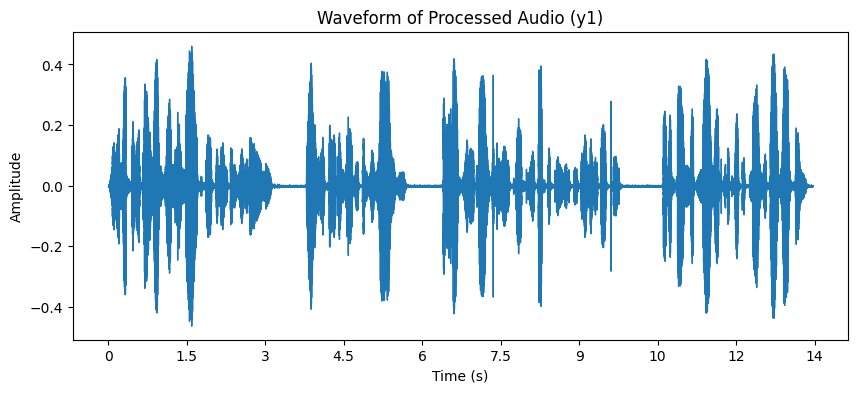

In [45]:
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

# Plot waveform of y1
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y1, sr=sr1)
plt.title("Waveform of Processed Audio (y1)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

Audio(y1, rate=sr1)

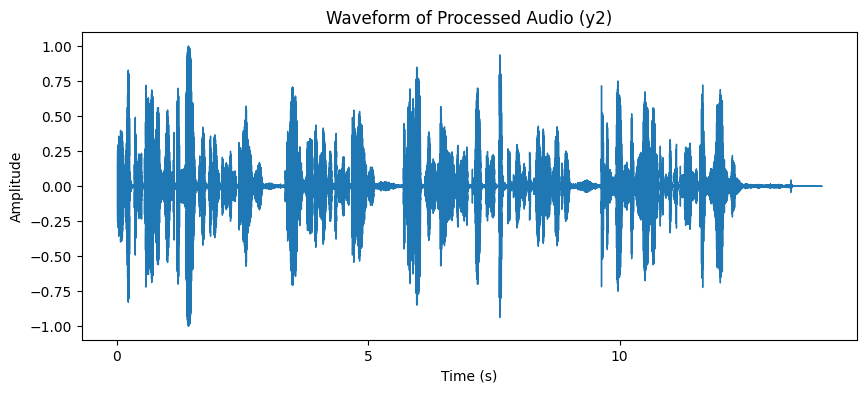

In [46]:
# Plot waveform of y2
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y2, sr=sr2)
plt.title("Waveform of Processed Audio (y2)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

Audio(y2, rate=sr2)

In [ ]:
sr2 16000

SyntaxError: invalid syntax (<ipython-input-6-5a6926f9fe14>, line 1)

In [47]:
# Resample both files to the same sample rate as 16k HZ
target_sr = 16000
if sr1 != target_sr:
    y1 = librosa.resample(y1, orig_sr=sr1, target_sr=target_sr)
if sr2 != target_sr:
    y2 = librosa.resample(y2, orig_sr=sr2, target_sr=target_sr)


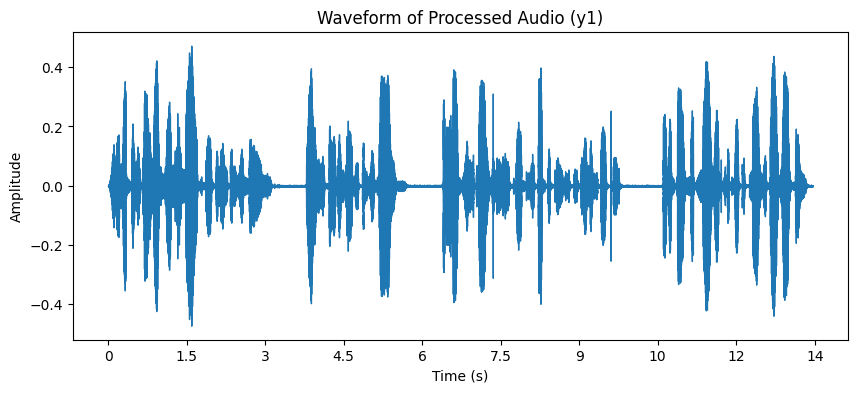

In [48]:
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

# Plot waveform of y1
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y1, sr=target_sr)
plt.title("Waveform of Processed Audio (y1)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

Audio(y1, rate=target_sr)

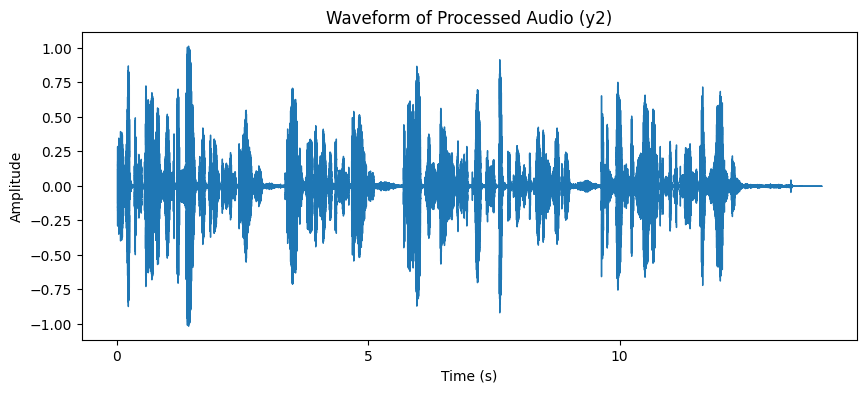

In [49]:
# Plot waveform of y2
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y2, sr=target_sr)
plt.title("Waveform of Processed Audio (y2)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

Audio(y2, rate=target_sr)

In [50]:
# Get basic properties
duration1 = librosa.get_duration(y=y1, sr=target_sr)
duration2 = librosa.get_duration(y=y2, sr=target_sr)

# Compute loudness (RMS energy)
rms1 = np.sqrt(np.mean(y1**2))
rms2 = np.sqrt(np.mean(y2**2))

# Compute spectral centroid (brightness of the sound)
centroid1 = np.mean(librosa.feature.spectral_centroid(y=y1, sr=target_sr))
centroid2 = np.mean(librosa.feature.spectral_centroid(y=y2, sr=target_sr))

# Compute zero-crossing rate (waveform shape differences)
zcr1 = np.mean(librosa.feature.zero_crossing_rate(y1))
zcr2 = np.mean(librosa.feature.zero_crossing_rate(y2))

# Output key differences
{
    "Duration (s)": (duration1, duration2),
    "RMS Loudness": (rms1, rms2),  #loudness
    "Spectral Centroid": (centroid1, centroid2),  #Brightness
    "Zero Crossing Rate": (zcr1, zcr2),
}

{'Duration (s)': (13.46, 14.0166875),
 'RMS Loudness': (0.03838167, 0.09223625),
 'Spectral Centroid': (2439.9849358832926, 2212.5363072482032),
 'Zero Crossing Rate': (0.21161019150831353, 0.17867868201879272)}

In [54]:
def match_rms(target, reference):
    rms_target = np.sqrt(np.mean(target**2))
    rms_reference = np.sqrt(np.mean(reference**2))
    gain = rms_reference / rms_target
    return target * gain  # Apply gain factor

# match loudness
y2_matched = match_rms(y2, y1)
rms1 = np.sqrt(np.mean(y1**2))
rms2 = np.sqrt(np.mean(y2_matched**2))
print(rms1,rms2)

#match brightness
y2_matched = librosa.effects.preemphasis(y2_matched, coef=0.22)
centroid1 = np.mean(librosa.feature.spectral_centroid(y=y1, sr=target_sr))
centroid2 = np.mean(librosa.feature.spectral_centroid(y=y2_matched, sr=target_sr))
print(centroid1,centroid2)

0.03838167 0.03838167
2439.9849358832926 2406.5681478281067


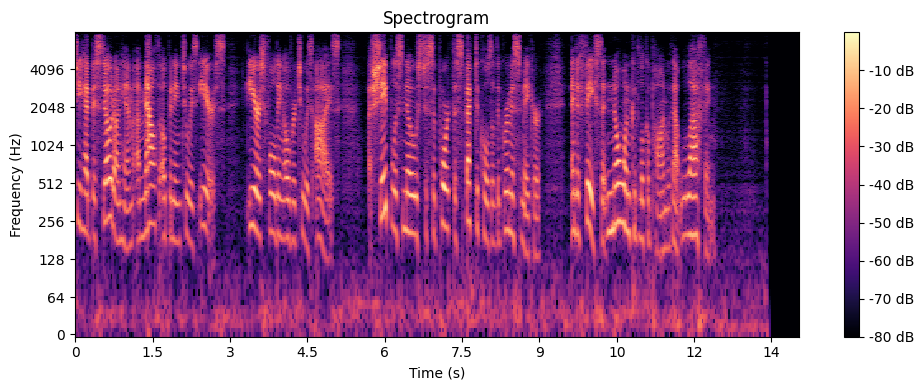

In [55]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y2)), ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=target_sr, x_axis='time', y_axis='log')  # Log scale for better visualization
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.tight_layout()
plt.show()

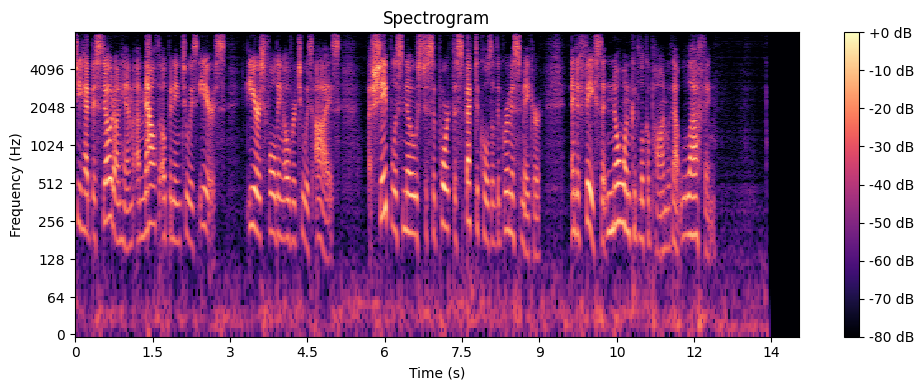

In [56]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y2_matched)), ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=target_sr, x_axis='time', y_axis='log')  # Log scale for better visualization
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.tight_layout()
plt.show()

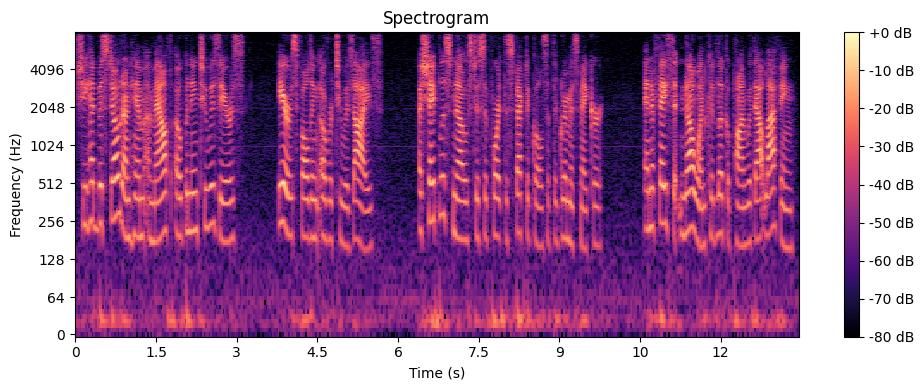

In [57]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y1)), ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=target_sr, x_axis='time', y_axis='log')  # Log scale for better visualization
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.tight_layout()
plt.show()

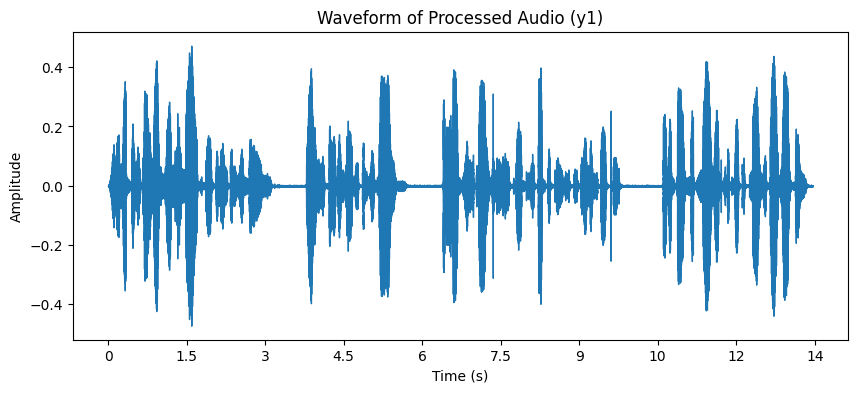

In [58]:
# Plot waveform of y1
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y1, sr=target_sr)
plt.title("Waveform of Processed Audio (y1)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

Audio(y1, rate=target_sr)

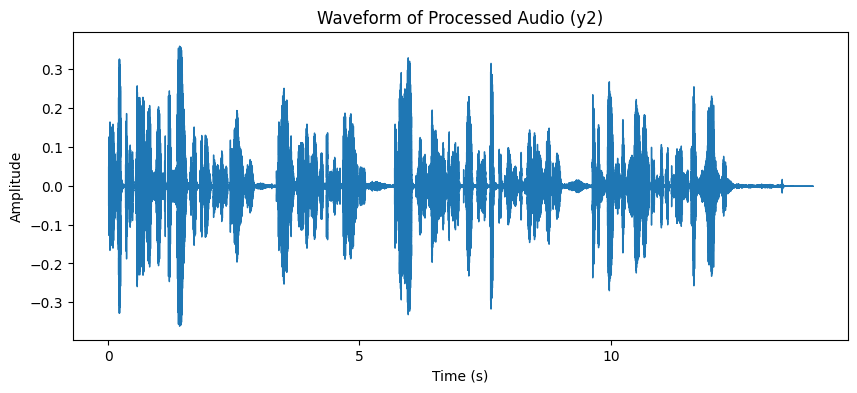

In [59]:
# Plot waveform of y2
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y2_matched, sr=target_sr)
plt.title("Waveform of Processed Audio (y2)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

Audio(y2_matched, rate=target_sr)

In [95]:
def replace_audio_segment(audio1, audio2, sr, start_time1, end_time1, start_time2, end_time2):

    # Convert time (seconds) to sample indices
    start_sample1 = int(start_time1 * sr)
    end_sample1 = int(end_time1 * sr)
    start_sample2 = int(start_time2 * sr)
    end_sample2 = int(end_time2 * sr)

    # Extract the segment from audio1
    segment = audio1[start_sample1:end_sample1]

    # Ensure audio2 is long enough to replace the segment
    #end_sample2 = start_sample2 + len(segment)
    if end_sample2 > len(audio2):
        raise ValueError("Segment replacement exceeds audio2 length!")

    # Replace the segment in audio2
    modified_audio2 = np.copy(audio2)
    #modified_audio2[start_sample2:end_sample2] = segment

    return segment
#start_times, end_times , start_times_f, end_times_f
# Define segment (time in seconds)
start_time1 = start_times_f[1]  # Start of the segment in audio1 (in seconds)
end_time1 = end_times_f[2]    # End of the segment in audio1 (in seconds)
start_time2 = end_times_f[2]  # Start in audio2 where the segment should be placed
end_time2 = start_times_f[3]
# Replace segment
modified_audio2 = replace_audio_segment(y2, y2_matched, target_sr, start_time1, end_time1, start_time2, end_time2)


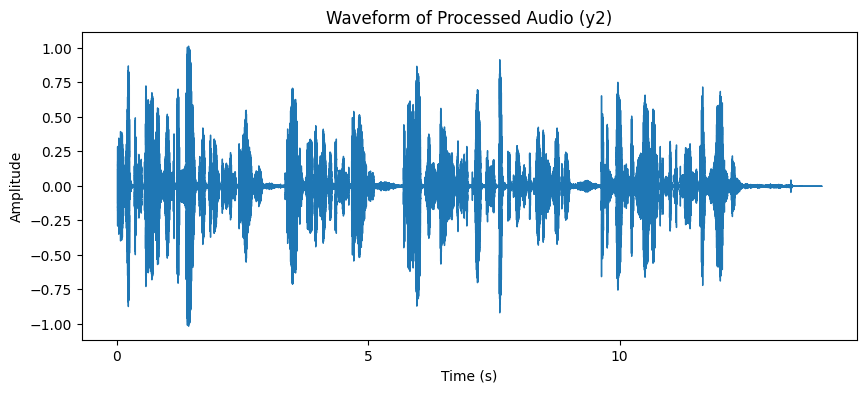

In [96]:
# Plot waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y2, sr=target_sr)
plt.title("Waveform of Processed Audio (y2)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

Audio(y2, rate=target_sr)
Audio(modified_audio2, rate=target_sr)